In [1]:
!pip install ta
!pip install yfinance --upgrade --no-cache-dir

In [2]:
# Data libaries
from datetime import datetime, timedelta
import yfinance as yf

# Model libaries
import sys
import pandas as pd
import numpy as np
import matplotlib as mpl
#import matplotlib.pyplot as plt
import math
import ta


import sklearn as sk
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#from tensorflow import keras
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.optimizers import SGD, Adam
from keras.losses import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional

tf.random.set_seed(20)
np.random.seed(10)

print(f"Python {sys.version}")
print(f"yfinance version is {yf.__version__}")
print(f"pandas version is {pd.__version__}")
print(f"numpy version is {np.__version__}")
print(f"matplotlib version is {mpl.__version__}")

print(f"tensorflow version is {tf.__version__}")
print(f"sklearn version is {sk.__version__}")

Python 3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
yfinance version is 0.1.69
pandas version is 1.1.5
numpy version is 1.19.5
matplotlib version is 3.2.2
tensorflow version is 2.7.0
sklearn version is 1.0.2


## Load the data (directly from YahooFinance)
With the following cell we can download each ticker available on yahoo finance. You simply have to adjust the dates,the tickername and the length of the new index 'x'. 

In [3]:
ticker = 'DAI.DE'

startDate = datetime(2011, 1, 1) # Start 1. jan 2011
#endDate = startDate + timedelta(365) # Timedelta would also be a possible solution
endDate = datetime(2021, 1, 1) # End 31. dec 2020

#The actual yahoofinance api call
member = yf.Ticker(ticker)
tickerData = member.history(start = startDate.strftime("%Y-%m-%d"),
    end= endDate.strftime("%Y-%m-%d"), interval = "1d")


# Fill the days where no data is available with zeros, so each week has the same length
idx = pd.date_range('01-01-2011', '01-01-2021', freq='C')
tickerData.index = pd.DatetimeIndex(tickerData.index)
tickerData = tickerData.reindex(idx, fill_value=0)

# Set a new index 'x' where we calculate sin and cos values from
tickerData["x"]=np.linspace(0,2610 -1,2610 , dtype=int)
tickerData.set_index(['x'])

tickerData.to_csv(r'/content/{}.csv'.format(ticker.rstrip('.DE'))) 

In [4]:
tickerData

,Open,High,Low,Close,Volume,Dividends,Stock Splits,x
2011-01-03,30.936772,31.629658,30.845602,31.429085,3097604,0.0,0,0
2011-01-04,31.453400,31.818076,31.009710,31.599272,3030350,0.0,0,1
2011-01-05,31.368305,32.833091,31.198123,32.577816,6930387,0.0,0,2
2011-01-06,32.517046,33.690091,32.413721,33.185619,5424381,0.0,0,3
2011-01-07,33.130914,33.921050,32.960732,33.143070,4977177,0.0,0,4
...,...,...,...,...,...,...,...,...
2020-12-28,58.403941,58.865595,57.441347,57.608330,2003600,0.0,0,2605
2020-12-29,58.128916,58.236963,56.910938,57.156498,1513662,0.0,0,2606
2020-12-30,56.969873,57.421702,56.685022,56.763603,1308817,0.0,0,2607
2020-12-31,0.000000,0.000000,0.000000,0.000000,0,0.0,0,2608


## Load the data (from csv)
In this task I will use an already downloaded .csv file with the Daimler stock. The It beginns at 1. jan 2011 and ends at 1. jan 2021, so exactly ten years of stock data.

In [5]:
tickerData = pd.read_csv(r'/content/DAI.csv')

### Date preperation

The normal trading times from Xetra are from 09:00 AM to 17:30 PM from monday till friday. \\
We want so assign to each row a specific yearly sin-and cos-value and a weekly sin-and cos-value, to identify possible connections between the day at which is traded. The idea to use sin-and cos-values for an alternative date representation is from the tensorflow/tutorials website (source: https://www.tensorflow.org/tutorials/structured_data/time_series, Last updated 2021-11-11 UTC).

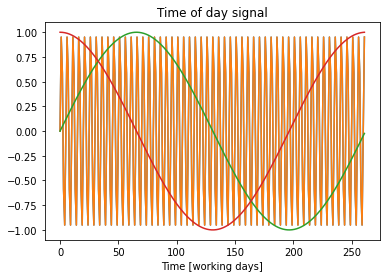

In [6]:
tickerData['Week sin'] = np.sin(tickerData["x"] * (2 * np.pi/ 5))
tickerData['Week cos'] = np.cos(tickerData["x"] * (2 * np.pi/ 5))
tickerData['Year sin'] = np.sin(tickerData["x"] * (2 * np.pi / 262))
tickerData['Year cos'] = np.cos(tickerData["x"] * (2 * np.pi / 262))

# Demonstration plot of the curves
mpl.pyplot.plot(np.array(tickerData['Week sin'])[:262])
mpl.pyplot.plot(np.array(tickerData['Week sin'])[:262])
mpl.pyplot.plot(np.array(tickerData['Year sin'])[:262])
mpl.pyplot.plot(np.array(tickerData['Year cos'])[:262])
mpl.pyplot.xlabel('Time [working days]')
mpl.pyplot.title('Time of day signal')

mpl.pyplot.show()

## Drop the empty columns
Right now there are still the empty colums left which we added to compute the exact sin-and cos-values in the cell above. \\
Since we don't want to confuse our model with empty colums and also want to boost the performance we will fill NAN values with the mean of the dataframe and then drop all rows with zeros. We also get rid of the colums we don't want to use, becaue they include little or irrelevant information. 

In [7]:
tickerData = tickerData.replace('?', np.nan)

tickerData.isnull().sum()
tickerData = tickerData.fillna(tickerData.mean())

indexNames = tickerData[ (tickerData['Volume'] == 0)].index 
tickerData.drop(indexNames , inplace=True)

tickerData.drop(columns=['x', 'Unnamed: 0'], axis=1, inplace=True) 
tickerData.shape

(2529, 11)

## Normalize the data
In order to boost the performance of the model we normalize the dataframe with the function StandardScaler. Also possible is the RobustScaler or the MinMaxScaler. We use two different Scalers for the X and Y set, so no information from the one set is transfered to the other trough the scaling. 

This cell also defines the X and Y sets and shifts the Y set by the defined timesteps into the future. After that we split the values into train_X, test_X, train_y, test_y and reframe train_X and test_X so the model can work with it.

In [8]:
columns = tickerData.columns.values.tolist()      

#X_scaler = MinMaxScaler()
#Y_scaler = MinMaxScaler()

#X_scaler = RobustScaler(quantile_range=(25.0,75.0))
#Y_scaler = RobustScaler(quantile_range=(25.0,75.0))

X_scaler = StandardScaler()
Y_scaler = StandardScaler()

future_prediction = -1

X_data = X_scaler.fit_transform(tickerData[columns])
Y_data = Y_scaler.fit_transform(tickerData.filter(['Close']).shift(periods=future_prediction, fill_value=0))

## Split the data into x and y sets
We split the scaled data into train_X, test_X, train_y, test_y with the function train_test_split. The size of the test set is 20% of the entire set.

In [9]:
# divide the data into train and test data
train_X, test_X, train_y, test_y = train_test_split(X_data, Y_data, test_size=0.20, shuffle=False)
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(2023, 11) (2023, 1) (506, 11) (506, 1)


## Generate a Timeseries
We use TimeseriesGenerator to generate a Timeseries which gives the DNN n_input many days to compute the forecast on. Since we train the model with the data in order the LSTM should memorize old data by itselff, so we don't have to increase the input size.

In [10]:
n_features = train_X.shape[1]
n_input = 3

generator_test = TimeseriesGenerator(test_X, test_y, length=n_input, sampling_rate=1, batch_size=1)
generator_train = TimeseriesGenerator(train_X, train_y, length=n_input , sampling_rate=1, batch_size=1)

## LSTM-Model
In this cell we define the model. We are using two LSTM Layers with a density of 500 neurons. And a Dropout Layer between to prevent overfitting.
At the end we use a Dense layer with one neuron which represents our predicted value. As optimizer we use the adam algorithm with the mean_squared_error als loss function. \\

we train the model 30 times (epochs) and adjust the weights after 5 days (batch_size).

## LSTM Model without technical indicators

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 1000)           4048000   
                                                                 
 lstm_1 (LSTM)               (None, 3, 1000)           8004000   
                                                                 
 lstm_2 (LSTM)               (None, 1000)              8004000   
                                                                 
 dense (Dense)               (None, 1)                 1001      
                                                                 
Total params: 20,057,001
Trainable params: 20,057,001
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
2020/2020 [==============================] - 437s 210ms/step - loss: 0.0300
Epoch 2/20
2020/2020 [==============================] - 412s 204ms/step - loss: 0.0240
Ep

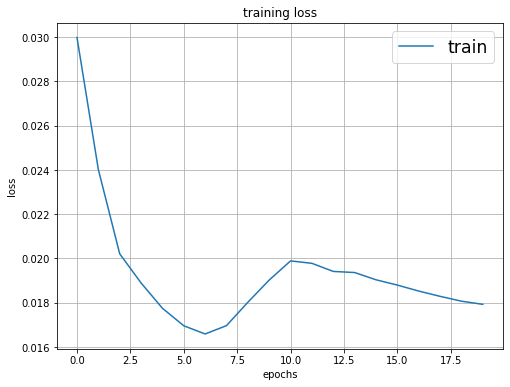

In [11]:
model2 = Sequential()
model2.add(LSTM(1000, return_sequences=True, input_shape=(n_input, n_features)))
model2.add(LSTM(1000, return_sequences=True))
model2.add(LSTM(1000, return_sequences=False))

model2.add(Dense(1))
model2.compile(loss='mse', optimizer=Adam(learning_rate=5e-5)) # learning_rate=1e-5 is optimal
model2.summary()

history = model2.fit(generator_train, steps_per_epoch=len(generator_train), epochs=20, verbose=1, shuffle=False)

# plot history
mpl.pyplot.figure(figsize=(8, 6))
mpl.pyplot.plot(history.history['loss'], label='train')
mpl.pyplot.legend(loc='best', fontsize='xx-large')
mpl.pyplot.grid()
mpl.pyplot.xlabel('epochs')
mpl.pyplot.ylabel('loss')
mpl.pyplot.title("training loss")
mpl.pyplot.show()

# Using technical Indicators

## Load the data (from csv)
In this task I will use an already downloaded .csv file with the Daimler stock. The It beginns at 1. jan 2011 and ends at 31. dec 2020, so exactly 10 years of stock data.

In [12]:
tickerData = pd.read_csv(r'/content/DAI.csv')

## Compute the technical indicators

In this cell we compute the most used technical indicators. I did not used all of them since some of them are controversial discussed. Most of the used indicators are pretty popular among traders. 

In [13]:
from ta.momentum import roc, rsi, stoch
from ta.volume import ease_of_movement, force_index
from ta.volatility import BollingerBands, bollinger_hband, bollinger_hband_indicator, bollinger_lband, bollinger_lband_indicator, bollinger_mavg, bollinger_pband
from ta.trend import sma_indicator,wma_indicator, ema_indicator, macd, macd_signal

####################################### momentum
# Rate of Change
tickerData['ROC2'] = roc(tickerData['Close'], 2, fillna=True)
tickerData['ROC3'] = roc(tickerData['Close'], 3, fillna=True)
tickerData['ROC4'] = roc(tickerData['Close'], 4, fillna=True)

tickerData['ROC9'] = roc(tickerData['Close'], 9, fillna=True)
tickerData['ROC14'] = roc(tickerData['Close'], 14, fillna=True)
tickerData['ROC5'] = roc(tickerData['Close'], 5, fillna=True)
tickerData['ROC7'] = roc(tickerData['Close'], 7, fillna=True)

# Relative Strength Index
tickerData['RSI2'] = roc(tickerData['Close'], 2, fillna=True)
tickerData['RSI3'] = roc(tickerData['Close'], 3, fillna=True)
tickerData['RSI4'] = roc(tickerData['Close'], 4, fillna=True)

tickerData['RSI9'] = roc(tickerData['Close'], 9, fillna=True)
tickerData['RSI14'] = roc(tickerData['Close'], 14, fillna=True)
tickerData['RSI5'] = roc(tickerData['Close'], 5, fillna=True)
tickerData['RSI7'] = roc(tickerData['Close'], 7, fillna=True)

# Stochastic Oscillator
tickerData['STOCH2%3'] = stoch(tickerData['Close'], tickerData['High'], tickerData['Low'], window=2, smooth_window=3, fillna=True)
tickerData['STOCH2%4'] = stoch(tickerData['Close'], tickerData['High'], tickerData['Low'], window=2, smooth_window=4, fillna=True)

tickerData['STOCH9%14'] = stoch(tickerData['Close'], tickerData['High'], tickerData['Low'], window=9, smooth_window=14, fillna=True)
tickerData['STOCH5%7'] = stoch(tickerData['Close'], tickerData['High'], tickerData['Low'], window=5, smooth_window=7, fillna=True)

####################################### volume
# variances
#tickerData['var2'] = tickerData['High'].rolling(window=2).var()
#tickerData['var3'] = tickerData['High'].rolling(window=3).var()

#tickerData['var5'] = tickerData['High'].rolling(window=5).var()
#tickerData['var10'] = tickerData['High'].rolling(window=10).var()

# Ease of movement
tickerData['EMV2'] = ease_of_movement(tickerData['High'], tickerData['Low'], tickerData['Volume'], window=2, fillna=True)
tickerData['EMV3'] = ease_of_movement(tickerData['High'], tickerData['Low'], tickerData['Volume'], window=3, fillna=True)

tickerData['EMV5'] = ease_of_movement(tickerData['High'], tickerData['Low'], tickerData['Volume'], window=5, fillna=True)
tickerData['EMV10'] = ease_of_movement(tickerData['High'], tickerData['Low'], tickerData['Volume'], window=10, fillna=True)

# Force Index
tickerData['FI2'] = force_index(tickerData['Close'], tickerData['Volume'], window=2, fillna=True)
tickerData['FI3'] = force_index(tickerData['Close'], tickerData['Volume'], window=3, fillna=True)

tickerData['FI5'] = force_index(tickerData['Close'], tickerData['Volume'], window=5, fillna=True)
tickerData['FI10'] = force_index(tickerData['Close'], tickerData['Volume'], window=10, fillna=True)

####################################### volatility
# Bollinger Bands
# Bollinger Channel Middle Band
tickerData['bb_bbm'] = bollinger_mavg(tickerData["Close"], 20, 2)

# Bollinger Channel High Band
tickerData['bb_bbh'] = bollinger_hband(tickerData["Close"], 20, 2)

# Bollinger Channel Low Band
tickerData['bb_bbl'] = bollinger_lband(tickerData["Close"], 20, 2)

# Bollinger Channel Indicator Crossing High Band
tickerData['bb_bbhi'] = bollinger_hband_indicator(tickerData["Close"], 20, 2)

# Bollinger Channel Indicator Crossing Low Band
tickerData['bb_bbli'] = bollinger_lband_indicator(tickerData["Close"], 20, 2)

# Bollinger Channel Percentage Band
tickerData['bb_pband'] = bollinger_pband(tickerData["Close"], 20, 2)

####################################### trend
# Simple Moving average
tickerData['SMA2'] = sma_indicator(tickerData['Close'], 2, fillna=True)
tickerData['SMA3'] = sma_indicator(tickerData['Close'], 3, fillna=True)


tickerData['SMA5'] = sma_indicator(tickerData['Close'], 5, fillna=True)
tickerData['SMA20'] = sma_indicator(tickerData['Close'], 20, fillna=True)
tickerData['SMA4'] = sma_indicator(tickerData['Close'], 4, fillna=True)
tickerData['SMA9'] = sma_indicator(tickerData['Close'], 9, fillna=True)

# Weighted Moving average
tickerData['WMA2'] = wma_indicator(tickerData['Close'], 2, fillna=True)
tickerData['WMA3'] = wma_indicator(tickerData['Close'], 3, fillna=True)


tickerData['WMA5'] = wma_indicator(tickerData['Close'], 5, fillna=True)
tickerData['WMA20'] = wma_indicator(tickerData['Close'], 20, fillna=True)
tickerData['WMA4'] = wma_indicator(tickerData['Close'], 4, fillna=True)
tickerData['WMA9'] = wma_indicator(tickerData['Close'], 9, fillna=True)

# Exponential Moving Average
tickerData['EMA2'] = ema_indicator(tickerData['Close'], 2, fillna=True)
tickerData['EMA3'] = ema_indicator(tickerData['Close'], 3, fillna=True)


tickerData['EMA5'] = ema_indicator(tickerData['Close'], 5, fillna=True)
tickerData['EMA20'] = ema_indicator(tickerData['Close'], 20, fillna=True)
tickerData['EMA4'] = ema_indicator(tickerData['Close'], 4, fillna=True)
tickerData['EMA9'] = ema_indicator(tickerData['Close'], 9, fillna=True)

# MACD

tickerData['MACD'] = macd(tickerData['Close'], window_slow = 26, window_fast = 12, fillna=True)
tickerData['MACDSignal'] = macd_signal(tickerData['Close'], window_slow = 26, window_fast = 12, fillna=True)

### Date preperation

The normal trading times from Xetra are from 09:00 AM to 17:30 PM from monday till friday. \\
We want so assign to each row a specific yearly sin-and cos-value and a weekly sin-and cos-value, to identify possible connections between the day at which is traded. The idea to use sin-and cos-values for an alternative date representation is from the tensorflow/tutorials website (source: https://www.tensorflow.org/tutorials/structured_data/time_series, Last updated 2021-11-11 UTC).

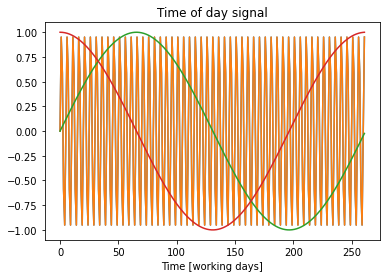

(2610, 65)

In [14]:
tickerData['Week sin'] = np.sin(tickerData["x"] * (2 * np.pi/ 5))
tickerData['Week cos'] = np.cos(tickerData["x"] * (2 * np.pi/ 5))
tickerData['Year sin'] = np.sin(tickerData["x"] * (2 * np.pi / 262))
tickerData['Year cos'] = np.cos(tickerData["x"] * (2 * np.pi / 262))

# Demonstration plot of the curves
mpl.pyplot.plot(np.array(tickerData['Week sin'])[:262])
mpl.pyplot.plot(np.array(tickerData['Week sin'])[:262])
mpl.pyplot.plot(np.array(tickerData['Year sin'])[:262])
mpl.pyplot.plot(np.array(tickerData['Year cos'])[:262])
mpl.pyplot.xlabel('Time [working days]')
mpl.pyplot.title('Time of day signal')

mpl.pyplot.show()
tickerData.shape

## Drop the empty columns
Right now there are still the empty colums left which we added to compute the exact sin-and cos-values in the cell above. \\
Since we don't want to confuse our model with empty colums and also want to boost the performance we will fill NAN values with the mean of the dataframe and then drop all rows with zeros. We also get rid of the colums we don't want to use, becaue they include little or irrelevant information. 

In [15]:
tickerData = tickerData.replace('?', np.nan)
tickerData.isnull().sum()
tickerData = tickerData.fillna(tickerData.mean())

indexNames = tickerData[ (tickerData['Volume'] == 0) ].index 

tickerData.drop(indexNames , inplace=True)
tickerData.drop(columns=['x', 'Unnamed: 0'], axis=1, inplace=True) 
tickerData.shape

(2529, 63)

## Normalize the data
In order to boost the performance of the model we normalize the dataframe with the function MinMaxScaler. After that our values are scaled between 0 and 1. \\
This cell also defines the X and X sets and shifts the Y set by one timestep into the future. After that we split the values into train_X, test_X, train_y, test_y and reframe train_X and test_X so the model can work with it.

In [16]:
columns = tickerData.columns.values.tolist()      

#X_scaler = RobustScaler(quantile_range=(25.0,75.0))
#Y_scaler = RobustScaler(quantile_range=(25.0,75.0))

X_scaler = StandardScaler()
Y_scaler = StandardScaler()

future_prediction = -1

X_data = X_scaler.fit_transform(tickerData[columns])
Y_data = Y_scaler.fit_transform(tickerData.filter(['Close']).shift(periods=future_prediction, fill_value=0))

## Split the data into x and y sets
We split the scaled data into train_X, test_X, train_y, test_y with the function train_test_split. The size of the test set is 20% of the entire set.

In [17]:
# divide the data into train and test data
train_X, test_X, train_y, test_y = train_test_split(X_data, Y_data, test_size=0.20, shuffle=False)
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(2023, 63) (2023, 1) (506, 63) (506, 1)


## Generate a Timeseries
We use TimeseriesGenerator to generate a Timeseries which gives the DNN n_input many days to compute the forecast on. 

In [18]:
n_features = train_X.shape[1]
n_input = 3

generator_test1 = TimeseriesGenerator(test_X, test_y, length=n_input, sampling_rate=1, batch_size=1)
generator_train1 = TimeseriesGenerator(train_X, train_y, length=n_input , sampling_rate=1, batch_size=1)

## LSTM-Model
In this cell we define the model. We are using two LSTM Layers with a density of 500 neurons. And a Dropout Layer between to prevent overfitting.
At the end we use a Dense layer with one neuron which represents our predicted value. As optimizer we use the adam algorithm with the mean_squared_error als loss function. \\

we train the model 30 times (epochs) and adjust the weights after 5 days (batch_size).

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 1000)           4048000   
                                                                 
 lstm_1 (LSTM)               (None, 3, 1000)           8004000   
                                                                 
 lstm_2 (LSTM)               (None, 1000)              8004000   
                                                                 
 dense (Dense)               (None, 1)                 1001      
                                                                 
Total params: 20,057,001
Trainable params: 20,057,001
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
2020/2020 [==============================] - 416s 203ms/step - loss: 0.0321
Epoch 2/20
2020/2020 [==============================] - 416s 206ms/step - loss: 0.0236
Ep

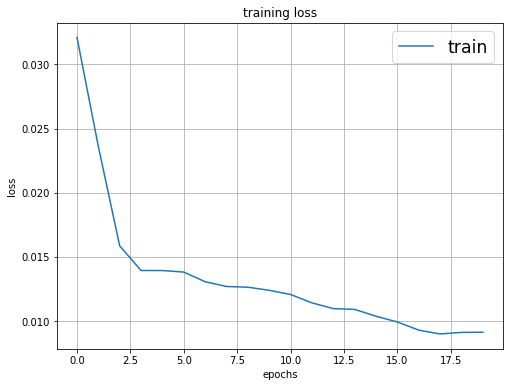

In [19]:
model4 = Sequential()
model4.add(LSTM(1000, return_sequences=True, input_shape=(n_input, n_features)))
model4.add(LSTM(1000, return_sequences=True))
model4.add(LSTM(1000, return_sequences=False))

model4.add(Dense(1))
model4.compile(loss='mse', optimizer=Adam(learning_rate=5e-5)) # learning_rate=1e-5 is optimal
model2.summary()

history = model4.fit(generator_train1, steps_per_epoch=len(generator_train1), epochs=20, verbose=1, shuffle=False)

# plot history
mpl.pyplot.figure(figsize=(8, 6))
mpl.pyplot.plot(history.history['loss'], label='train')
mpl.pyplot.legend(loc='best', fontsize='xx-large')
mpl.pyplot.grid()
mpl.pyplot.xlabel('epochs')
mpl.pyplot.ylabel('loss')
mpl.pyplot.title("training loss")
mpl.pyplot.show()

## Model prediction and evaluation

We use this code to evaluate and compare the actual test_y data with the predicted test_y data.

In [20]:
model2_predicted_values_scaled = model2.predict(generator_test, verbose=0)
model4_predicted_values_scaled = model4.predict(generator_test1, verbose=0)

In [21]:
model2_pred = Y_scaler.inverse_transform(model2_predicted_values_scaled)[(-future_prediction)-1 :200 + (-future_prediction) -1]
print(f"Model prediction dimension{model2_pred.shape}")

model4_pred = Y_scaler.inverse_transform(model4_predicted_values_scaled)[(-future_prediction)-1 :200 + (-future_prediction) -1]
print(f"Model prediction dimension{model4_pred.shape}")


real = Y_scaler.inverse_transform(test_y)[n_input:200 + n_input]
print(f"Real price dimension{real.shape}")

Model prediction dimension(200, 1)
Model prediction dimension(200, 1)
Real price dimension(200, 1)


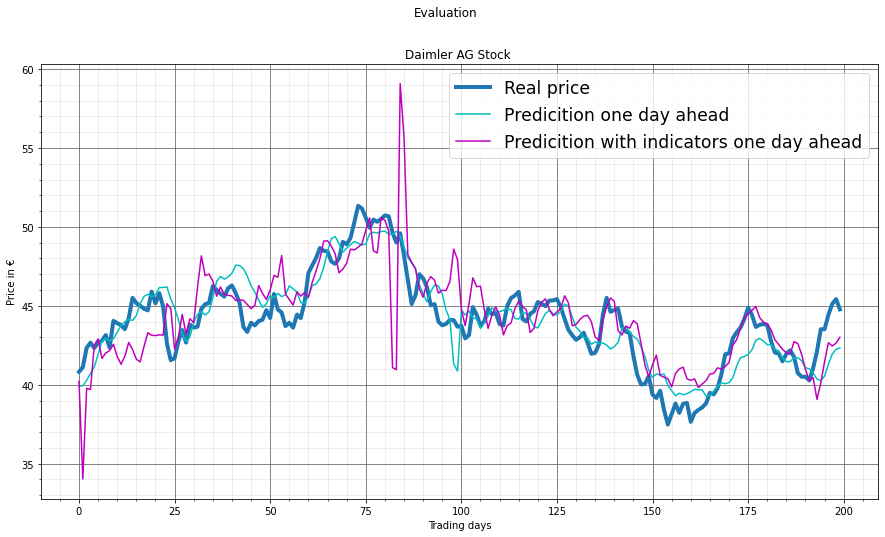

In [22]:
fig, ax = mpl.pyplot.subplots(1, figsize=(15, 8))
fig.suptitle('Evaluation')

x_axis = np.arange(0,200,1)

ax.plot(x_axis, real, linewidth=4, label="Real price")
ax.plot(x_axis, model2_pred, 'c' ,label="Predicition one day ahead")
ax.plot(x_axis, model4_pred, 'm' ,label="Predicition with indicators one day ahead")


mpl.pyplot.legend(loc='best', fontsize='xx-large')

mpl.pyplot.grid(b=True, which='major', color='#666666', linestyle='-')
mpl.pyplot.minorticks_on()
mpl.pyplot.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

mpl.pyplot.xlabel('Trading days')
mpl.pyplot.ylabel('Price in €')
mpl.pyplot.title("Daimler AG Stock ")
mpl.pyplot.savefig(r'/content/model_comparison_200days.jpg')
mpl.pyplot.show()

In [23]:
model2_pred = Y_scaler.inverse_transform(model2_predicted_values_scaled)[(-future_prediction)-1 :30 + (-future_prediction) -1]
print(f"Model prediction dimension{model2_pred.shape}")

model4_pred = Y_scaler.inverse_transform(model4_predicted_values_scaled)[(-future_prediction)-1 :30 + (-future_prediction) -1]
print(f"Model prediction dimension{model4_pred.shape}")


real = Y_scaler.inverse_transform(test_y)[n_input:30 + n_input]
print(f"Real price dimension{real.shape}")

Model prediction dimension(30, 1)
Model prediction dimension(30, 1)
Real price dimension(30, 1)


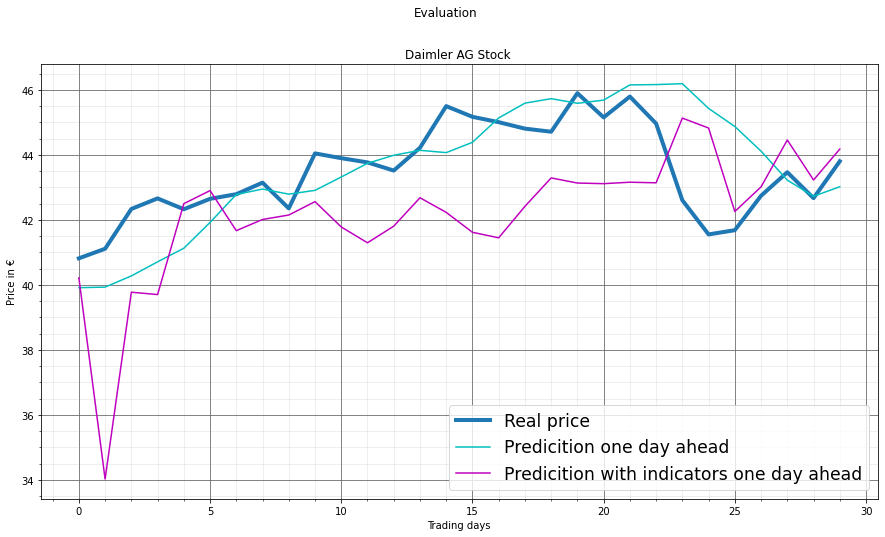

In [24]:
fig, ax = mpl.pyplot.subplots(1, figsize=(15, 8))
fig.suptitle('Evaluation')

x_axis = np.arange(0,30,1)

ax.plot(x_axis, real, linewidth=4, label="Real price")
ax.plot(x_axis, model2_pred, 'c' ,label="Predicition one day ahead")
ax.plot(x_axis, model4_pred, 'm' ,label="Predicition with indicators one day ahead")


mpl.pyplot.legend(loc='best', fontsize='xx-large')

mpl.pyplot.grid(b=True, which='major', color='#666666', linestyle='-')
mpl.pyplot.minorticks_on()
mpl.pyplot.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

mpl.pyplot.xlabel('Trading days')
mpl.pyplot.ylabel('Price in €')
mpl.pyplot.title("Daimler AG Stock ")
mpl.pyplot.savefig(r'/content/model_comparison_30days.jpg')
mpl.pyplot.show()